# Ensemble Learning Notebook
This notebook covers key ensemble techniques:
- **Bootstrapping**
- **Bagging**
- **Random Forests**
- **Boosting**

You will see both conceptual explanations and hands-on code examples using scikit-learn.

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## 1. Bootstrapping

**What is bootstrapping?**  
Bootstrapping is the process of sampling **with replacement** from an original dataset to create a new “bootstrap” dataset of the same size. Each bootstrap sample will omit some points and duplicate others. We then use these resampled datasets to train multiple models (as in bagging), or to estimate sampling distributions of statistics.

**Why with replacement?**  
- Ensures each draw is independent.  
- Roughly 63.2% of the original unique points appear in each sample; the remaining 36.8% are “out-of-bag” (OOB).

**Key properties**  
- Allows estimation of variance, bias, and confidence intervals by looking at the distribution of statistics over many bootstrap samples.  
- Serves as the backbone of bagging: train one base learner per bootstrap sample and aggregate.

---



In [5]:
import numpy as np

# 1. Create a toy dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=4, n_informative=2, random_state=42)
data = np.column_stack((X, y))

# 2. Draw one bootstrap sample
N = data.shape[0]
rng = np.random.RandomState(42)
indices = rng.choice(N, size=N, replace=True)
bootstrap_sample = data[indices]

# 3. Compare counts
print(f"Original samples: {N}")
print(f"Unique samples in bootstrap: {len(np.unique(indices))}")
# Show which indices are OOB
oob_mask = np.ones(N, dtype=bool)
oob_mask[np.unique(indices)] = False
print(f"OOB samples count: {oob_mask.sum()}")
print(f"OOB indices (first 10): {np.where(oob_mask)[0][:10]}")

Original samples: 100
Unique samples in bootstrap: 61
OOB samples count: 39
OOB indices (first 10): [ 0  4  9 10 11 12 15 16 18 19]


<IPython.core.display.Javascript object>

Empirical mean unique: 63.4
Theoretical (63.2% of 100): 63.2
54
72


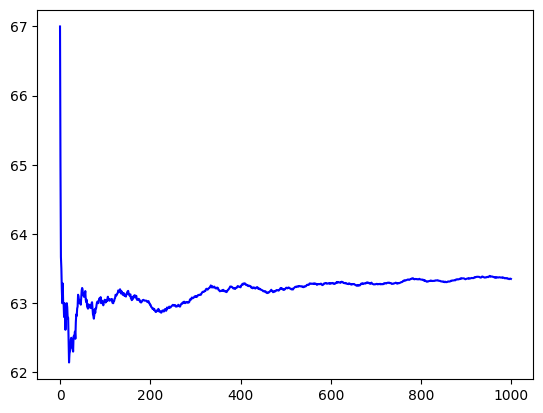

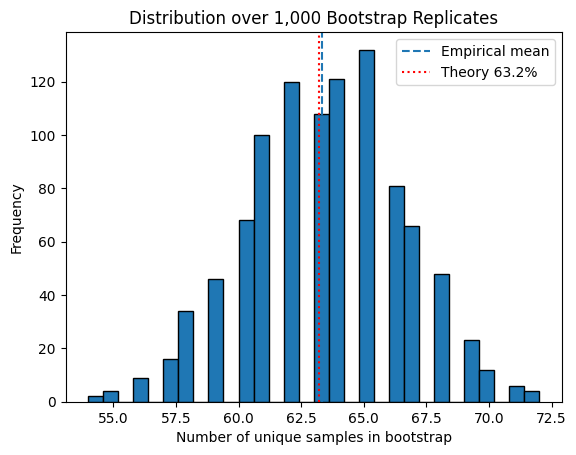

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import time

# Simulate many bootstraps to see variability in unique counts


plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], "b-")

n_reps = 1000
unique_counts = []
mean_unique = []
repetition = []
for i in range(n_reps):
    idx = rng.choice(N, size=N, replace=True)
    unique_counts.append(len(np.unique(idx)))
    repetition.append(i)
    mean_unique.append(np.array(unique_counts).mean())

    line.set_xdata(repetition)
    line.set_ydata(mean_unique)
    
    ax.relim()
    ax.autoscale_view()
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()

unique_counts = np.array(unique_counts)
%matplotlib inline
import matplotlib.pyplot as plt
# Theoretical expected unique count ≈ N*(1 - 1/e)
print(f"Empirical mean unique: {unique_counts.mean():.1f}")
print(f"Theoretical (63.2% of 100): {100*(1 - 1/np.e):.1f}")
print(min(unique_counts))
print(max(unique_counts))

plt.figure()
plt.hist(unique_counts, bins=30, edgecolor='k')
plt.axvline(unique_counts.mean(), linestyle='--', label='Empirical mean')
plt.axvline(100*(1 - 1/np.e), color='r', linestyle=':', label='Theory 63.2%')
plt.xlabel("Number of unique samples in bootstrap")
plt.ylabel("Frequency")
plt.title("Distribution over 1,000 Bootstrap Replicates")
plt.legend()
plt.show()


### Proof of the 63.2% Limit

We want to show that when you draw $N$ samples **with replacement** from a dataset of size $N$, the expected fraction of **unique** items in the bootstrap sample tends to
$$
1 - \tfrac{1}{e} \approx 0.6321 \; (63.21\%).
$$

1. **Probability an item is never picked**  
   On each of the $N$ draws, the chance of **not** selecting a particular item $i$ is
   $$
   1 - \frac{1}{N}\,.
   $$
   Since draws are independent (with replacement), the probability item $i$ is **never** picked in the entire bootstrap sample is
   $$
   \Bigl(1 - \tfrac{1}{N}\Bigr)^{N}.
   $$

2. **Probability an item is picked at least once**  
   The complement gives the chance that item $i$ **is** picked at least once:
   $$
   1 - \Bigl(1 - \tfrac{1}{N}\Bigr)^{N}.
   $$

3. **Expected number of unique items**  
   By the linearity of expectation, the expected count of unique items in the bootstrap sample is
   $$
   N \times \Bigl[\,1 - \bigl(1 - \tfrac{1}{N}\bigr)^{N}\Bigr].
   $$
   Hence the **fraction** of unique items is
   $$
   1 - \Bigl(1 - \tfrac{1}{N}\Bigr)^{N}.
   $$

4. **Limit as $N \to \infty$**  
   Recall the standard limit
   $$
   \lim_{N\to\infty}\Bigl(1 - \tfrac{1}{N}\Bigr)^{N} = e^{-1}\,.
   $$
   Therefore,
   $$
   \lim_{N\to\infty}\Bigl[\,1 - (1 - 1/N)^N\Bigr]
   \;=\; 1 - e^{-1}
   \;\approx\; 0.6321 \;=\; 63.21\%.
   $$

---

**Practice**: Plot the expected count to see the convergece your self.


## 2. Bagging

**What is Bagging?**  
Bagging (Bootstrap AGGregatING) builds an ensemble by training multiple copies of a base learner on different **bootstrap** samples and aggregating their predictions. This reduces variance without substantially increasing bias.

**Key Steps**  
1. **Bootstrap sampling**: Draw $B$ bootstrap datasets (size $N$, with replacement) from the original training set.  
2. **Model training**: Train one base estimator (e.g., a decision tree) on each bootstrap sample.  
3. **Aggregation**:  
   - **Classification**: majority vote  
   - **Regression**: average  

**Why bagging helps**  
- Variance reduction through averaging of uncorrelated errors  
- Built-in **OOB (out-of-bag)** error estimate  
- Easily parallelizable

---

## 2. Bagging with Decision Trees

In [7]:
class BaggingClassifier:
    def __init__(self, base_classifier, n_estimators):
        self.base_classifier = base_classifier
        self.n_estimators = n_estimators
        self.classifiers = []
        
    def fit(self, X, y):
          for _ in range(self.n_estimators):
              # Bootstrap sampling with replacement
              indices = np.random.choice(len(X), len(X), replace=True)
              X_sampled = X[indices]
              y_sampled = y[indices]

              # Create a new base classifier and train it on the sampled data
              classifier = self.base_classifier.__class__()
              classifier.fit(X_sampled, y_sampled)

              # Store the trained classifier in the list of classifiers
              self.classifiers.append(classifier)
          return self.classifiers
    def predict(self, X):
        # Make predictions using all the base classifiers
        predictions = [classifier.predict(X) for classifier in self.classifiers]
        # Aggregate predictions using majority voting
        majority_votes = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)

        return majority_votes

In [8]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

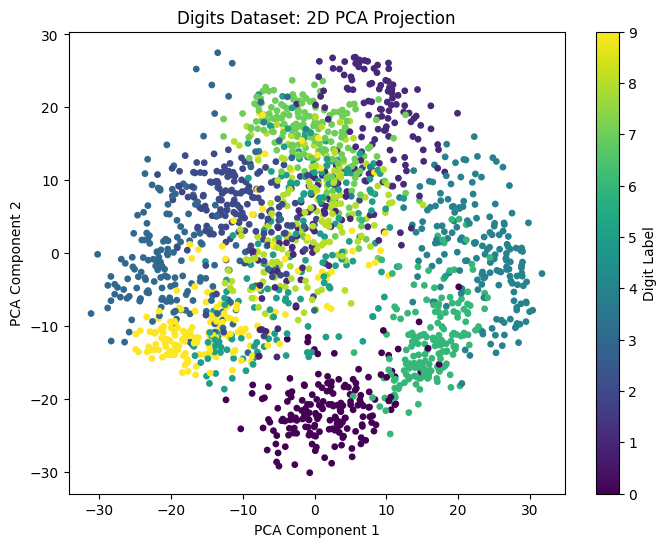

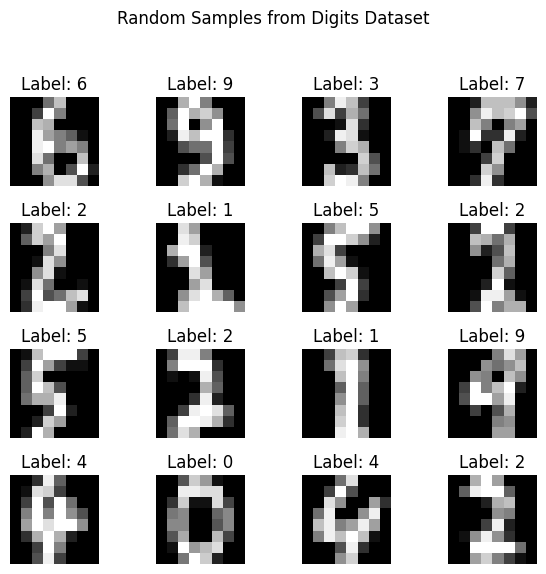

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
import numpy as np

# Load the dataset
digits = load_digits()
X, y = digits.data, digits.target

# 1. PCA scatter plot
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=15)
cbar = plt.colorbar(scatter)
cbar.set_label('Digit Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Digits Dataset: 2D PCA Projection')
plt.show()

# 2. Sample images grid
num_images = 16
indices = np.random.RandomState(42).choice(len(X), size=num_images, replace=False)
sample_images = X[indices]
sample_labels = y[indices]

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for ax, img, label in zip(axes.ravel(), sample_images, sample_labels):
    ax.imshow(img.reshape(8, 8), interpolation='nearest', cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.suptitle('Random Samples from Digits Dataset')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
# Load the dataset
digit = load_digits()
X, y = digit.data, digit.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the base classifier
dc = DecisionTreeClassifier()
model = BaggingClassifier(base_classifier=dc, n_estimators=10)
classifiers = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9305555555555556


In [11]:
for i, clf in enumerate(classifiers):
    y_pred = clf.predict(X_test)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:"+str(i+1),':', accuracy)

Accuracy:1 : 0.8361111111111111
Accuracy:2 : 0.8305555555555556
Accuracy:3 : 0.8166666666666667
Accuracy:4 : 0.8388888888888889
Accuracy:5 : 0.8138888888888889
Accuracy:6 : 0.8277777777777777
Accuracy:7 : 0.8416666666666667
Accuracy:8 : 0.825
Accuracy:9 : 0.8527777777777777
Accuracy:10 : 0.85


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

# 1. Prepare data
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.3, random_state=42
)

# 2. Train a single decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print("Single tree accuracy:", accuracy_score(y_test, dt.predict(X_test)))

# 3. Train a bagging ensemble
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    oob_score=True,
    random_state=42,
)
bag.fit(X_train, y_train)

# 4. Evaluate
print("Bagging accuracy:", accuracy_score(y_test, bag.predict(X_test)))
print("OOB score estimate:", bag.oob_score_)


Single tree accuracy: 1.0
Bagging accuracy: 1.0
OOB score estimate: 0.9238095238095239


## 3. Random Forest

![](https://media.geeksforgeeks.org/wp-content/uploads/20250627112439534287/Random-forest-algorithm.webp)

**Working of the Random Forest Algorithm**  
1. **Create many decision trees** – each tree is trained on a different bootstrap sample of the data.  
2. **Pick random features** – at each split, a tree only considers a random subset of features, which further de-correlates the trees.  
3. **Each tree makes a prediction** – classification trees vote on class; regression trees average their outputs.  
4. **Combine the predictions** – majority vote for classification, mean for regression.  

![](https://media.geeksforgeeks.org/wp-content/uploads/20250627112440591571/Random-Forest.webp)
![](https://media.geeksforgeeks.org/wp-content/uploads/20250627112439890354/Random-Forest-Effectiveness.webp)


> *Why it works:* randomness in sampling **and** features reduces over-fitting and yields more accurate, robust models.

---

**Assumptions**  
- Individual trees are independent (no tree’s prediction influences another)  
- Random subsets of data and features ensure diversity  

---



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_data = pd.read_csv(url)

titanic_data = titanic_data.dropna(subset=['Survived'])

X = titanic_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = titanic_data['Survived']

X.loc[:, 'Sex'] = X['Sex'].map({'female': 0, 'male': 1})

X.loc[:, 'Age'].fillna(X['Age'].median(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

sample = X_test.iloc[0:1]
prediction = rf_classifier.predict(sample)

sample_dict = sample.iloc[0].to_dict()
print(f"\nSample Passenger: {sample_dict}")
print(f"Predicted Survival: {'Survived' if prediction[0] == 1 else 'Did Not Survive'}")
print(y_test[0:1])

Accuracy: 0.80

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.84       105
           1       0.82      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.80      0.80       179


Sample Passenger: {'Pclass': 3, 'Sex': 1, 'Age': 28.0, 'SibSp': 1, 'Parch': 1, 'Fare': 15.2458}
Predicted Survival: Did Not Survive
709    1
Name: Survived, dtype: int64


### Implementing Random Forest for Regression Tasks

In [14]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

california_housing = fetch_california_housing()
california_data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
california_data['MEDV'] = california_housing.target

X = california_data.drop('MEDV', axis=1)
y = california_data['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

single_data = X_test.iloc[0].values.reshape(1, -1)
predicted_value = rf_regressor.predict(single_data)
print(f"Predicted Value: {predicted_value[0]:.2f}")
print(f"Actual Value: {y_test.iloc[0]:.2f}")

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Predicted Value: 0.51
Actual Value: 0.48
Mean Squared Error: 0.26
R-squared Score: 0.81



### Discussion Questions
   - How does increasing the number of trees $\texttt{n\_estimators}$ affect accuracy, computation time, and memory?  
   - When might you need to tune other hyperparameters (e.g., $\texttt{max\_depth}, \texttt{min\_samples\_leaf}$) to combat overfitting or underfitting?
   - How would you adapt Random Forests for multi-output regression or for tasks with imbalanced classes?